This notebook allows to explore the results of predicting the `click_rate` from `source_article` to `target_article` using different models (Doc2Vec, Wikipedia2Vec, Smash-RNN Paragraph Level, Smash-RNN Sentence Level and Smash-RNN Word Level).

The class `ResultsAnalyzer` encapsules the logic to compute the results. Main features:
- `get_ndcg_for_all_models`: Calculates the Normalized Discounted Cumulative Gain for each model
- `get_map_for_all_models`: Calculates the Mean Average Precision for each model
- `get_top_5_predicted_by_article_and_model(source_article, model)`: Gets the top 5 predictions for the `source_article`. The column `is_in_top_5` shows if the `target_article` is in the **actual** top 5 click rate.
- `ResultsAnalyzer.results`: It is a Pandas Datafram containing the consolidated results
- `get_sample_source_articles`: Samples 10 random `source_articles`. Can be used to manually check the results

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from results_analyzer import ResultsAnalyzer

pd.options.display.float_format = '{:,.4f}'.format
results_analyzer = ResultsAnalyzer()

In /Users/dnascimentodepau/anaconda3/envs/thesis-davi/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/dnascimentodepau/anaconda3/envs/thesis-davi/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/dnascimentodepau/anaconda3/envs/thesis-davi/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/dnascimentodepau/anaconda3/envs/thesis-davi/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotli

In [20]:
WORD_COUNT_BIN = "word_count_bin"
WORD_COUNT_COLUMN = "word_count"
OUT_LINKS_BIN = "out_links_bin"
OUT_LINKS_COLUMN= "out_links_count"
IN_LINKS_BIN = "in_links_bin"
IN_LINKS_COLUMN = "in_links_count"
PARAGRAPH_COUNT_COLUMN = "paragraph_count"
PARAGRAPH_COUNT_BIN = "paragraph_count_bin"
SENTENCE_COUNT_COLUMN = "sentence_count"
SENTENCE_COUNT_BIN = "sentence_count_bin"
MISSING_WORDS_COLUMN = "missing_words_percentage"
MISSING_WORDS_BIN = "missing_words_percentage_bin"
MODEL_COLUMN = "model"

ALL_FEATURES = [WORD_COUNT_COLUMN, OUT_LINKS_COLUMN, IN_LINKS_COLUMN]

DOC2VEC_SIAMESE = "doc2vec_siamese"
DOC2VEC_COSINE = "doc2vec_cosine"
WIKIPEDIA2VEC_SIAMESE = "wikipedia2vec_siamese"
WIKIPEDIA2VEC_COSINE = "wikipedia2vec_cosine"
SMASH_WORD_LEVEL = "smash_word_level"
SMASH_SENTENCE_LEVEL = "smash_sentence_level"
SMASH_PARAGRAPH_LEVEL = "smash_paragraph_level"
SMASH_WORD_LEVEL_INTRODUCTION = "smash_word_level_introduction"
SMASH_SENTENCE_LEVEL_INTRODUCTION = "smash_sentence_level_introduction"
SMASH_PARAGRAPH_LEVEL_INTRODUCTION = "smash_paragraph_level_introduction"

ALL_MODELS = [DOC2VEC_SIAMESE, 
              DOC2VEC_COSINE, 
              WIKIPEDIA2VEC_SIAMESE, 
              WIKIPEDIA2VEC_COSINE, 
              SMASH_WORD_LEVEL, 
              SMASH_SENTENCE_LEVEL,
              SMASH_PARAGRAPH_LEVEL, 
              SMASH_WORD_LEVEL_INTRODUCTION,
              SMASH_SENTENCE_LEVEL_INTRODUCTION,
              SMASH_PARAGRAPH_LEVEL_INTRODUCTION]

INTRODUCTION_MODELS = [SMASH_WORD_LEVEL_INTRODUCTION,
                       SMASH_SENTENCE_LEVEL_INTRODUCTION,
                       SMASH_PARAGRAPH_LEVEL_INTRODUCTION]

COMPLETE_MODELS = [DOC2VEC_SIAMESE, 
                   WIKIPEDIA2VEC_SIAMESE,  
                   SMASH_WORD_LEVEL, 
                   SMASH_SENTENCE_LEVEL,
                   SMASH_PARAGRAPH_LEVEL]

COMPLETE_MODELS_SAVE_CONFIG = [
    (PARAGRAPH_COUNT_COLUMN, "Source article length as paragraph count (%s equal-sized buckets)"),
    (SENTENCE_COUNT_COLUMN, "Source article length as sentence count (%s equal-sized buckets)"),
    (WORD_COUNT_COLUMN, "Source article length as word count (%s equal-sized buckets)"),
    (OUT_LINKS_COLUMN, "Number of links present in the source articles (%s equal-sized buckets)"),
    (IN_LINKS_COLUMN, "Number of articles with links pointing to the source articles (%s equal-sized buckets)"),
    (MISSING_WORDS_COLUMN, "Percentage of missing words in GloVe (%s equal-sized buckets)")
]

SMASH_MODELS = [SMASH_WORD_LEVEL, 
                SMASH_SENTENCE_LEVEL,
                SMASH_PARAGRAPH_LEVEL,]

COSINE_MODELS = [DOC2VEC_SIAMESE, 
                 WIKIPEDIA2VEC_SIAMESE,
                 DOC2VEC_COSINE, 
                 WIKIPEDIA2VEC_COSINE]

BEST_MODELS = [DOC2VEC_SIAMESE,
               SMASH_WORD_LEVEL,
               WIKIPEDIA2VEC_SIAMESE]

CLEAN_MODEL_NAMES = {
    DOC2VEC_SIAMESE: "Doc2Vec",
    DOC2VEC_COSINE: "Doc2Vec Cosine",
    WIKIPEDIA2VEC_SIAMESE: "Wikipedia2Vec", 
    WIKIPEDIA2VEC_COSINE: "Wikipedia2Vec Cosine", 
    SMASH_WORD_LEVEL: "SMASH RNN (P + S + W)", 
    SMASH_SENTENCE_LEVEL: "SMASH RNN (P + S)",
    SMASH_PARAGRAPH_LEVEL: "SMASH RNN (P)", 
    SMASH_WORD_LEVEL_INTRODUCTION: "SMASH RNN Introduction (P + S + W)",
    SMASH_SENTENCE_LEVEL_INTRODUCTION: "SMASH RNN Introduction (P + S)",
    SMASH_PARAGRAPH_LEVEL_INTRODUCTION: "SMASH RNN Introduction (P)",
}


Getting NDCG for all models:

In [3]:
_results = results_analyzer.calculate_statistics_per_group()

[2020-10-30 14:07:49,048] [INFO] Getting features from DB (calculate_statistics_per_group@results_analyzer.py:375)
[2020-10-30 14:07:49,369] [INFO] Getting predictions by model (calculate_statistics_per_group@results_analyzer.py:394)
[2020-10-30 14:07:49,381] [INFO] Aggregating predictions for each model (get_predictions_by_model@results_analyzer.py:278)
100%|██████████| 10/10 [00:07<00:00,  1.39it/s]
[2020-10-30 14:07:56,613] [INFO] Calculating results by model (calculate_statistics_per_group@results_analyzer.py:451)
100%|██████████| 474/474 [00:03<00:00, 134.85it/s]


In [4]:
def get_latex(models):
    clean_names = {k: v for k, v in CLEAN_MODEL_NAMES.items() if k in models}
    models_results = _results[models].mean()
    models_results.rename(index=clean_names, inplace=True)
    
    print(models_results.to_latex())
    
get_latex(SMASH_MODELS)

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
SMASH RNN (P + S + W) & 0.5396 \\
SMASH RNN (P + S)     & 0.5165 \\
SMASH RNN (P)         & 0.5241 \\
\bottomrule
\end{tabular}



In [35]:
SMASH_HATCH = '//'
DOC2VEC_HATCH = 'X' 
WIKIPEDIA2VEC_HATCH = '.'

system_styles = {
    'doc2vec_siamese': dict(color='#b2abd2', hatch=DOC2VEC_HATCH),
    'wikipedia2vec_siamese': dict(color='#e66101', hatch=WIKIPEDIA2VEC_HATCH),
    'smash_paragraph_level': dict(color='#abdda4'),
    'smash_sentence_level': dict(color='#fdae61'),
    'smash_word_level': dict(color='#2b83ba'),
}

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE+1)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE+1)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE+1)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

def get_performance_figure(
    results,
    models,
    feature_column,
    x_label,
    y_label=None,
    figsize=(13, 6),
    legend_columns_count=3,
    buckets_count=5,
    save_file_name=None,
):
    bin_column = f"{feature_column}_bin"
    bins = pd.qcut(results[feature_column], q=buckets_count)

    results[bin_column] = bins
    result_by_model = results.groupby([bin_column]).mean()[models]

    fig = plt.figure(figsize=figsize)

    ax = result_by_model.plot(
        kind="bar", ax=fig.gca(), rot=0, width=0.7, alpha=0.9, edgecolor=["black"],
    )

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.25, box.width, box.height * 0.75])

    # Formats the bars
    for container in ax.containers:
        container_system = container.get_label()
        
        style = system_styles[container_system]
        for patch in container.patches:
            if 'color' in style:
                patch.set_color(style['color'])
            if 'hatch' in style:
                patch.set_hatch(style['hatch'])
            if 'linewidth' in style:
                patch.set_linewidth(style['linewidth'])
            if 'edgecolor' in style:
                patch.set_edgecolor(style['edgecolor'])
            else:
                patch.set_edgecolor('black')

    
    model_names = [CLEAN_MODEL_NAMES[model] for model in selected_models]

    ax.legend(
        model_names,
        ncol=legend_columns_count,
        loc="upper center",
        fancybox=True,
        shadow=False,
        bbox_to_anchor=(0.5, 1.2),
    )

    # Formats the x label as "(lower, upper]"
    ax.set_xticklabels(
        [f"({int(i.left)}, {int(i.right)}]" for i in bins.cat.categories]
    )

    y_label = "NDCG@k (k=5)"
    ax.set_xlabel(x_label % len(result_by_model))
    ax.set_ylabel(y_label)
    
    if save_file_name:
        save_file_path = f"./results/figures/{save_file_name}.png"
        pdf_dpi = 300

#         logger.info(f"Saved to {save_file_path}")
        plt.savefig(save_file_path, bbox_inches="tight", dpi=pdf_dpi)

    plt.show()

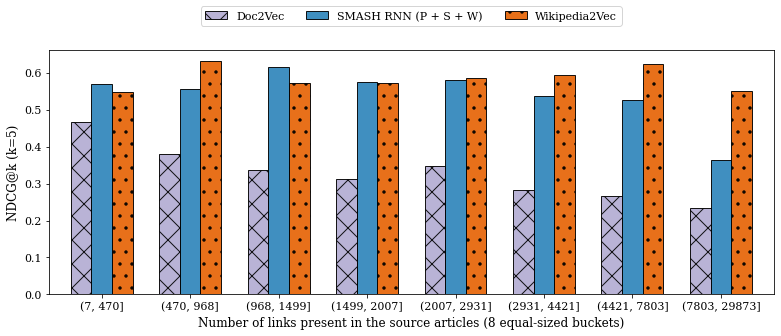

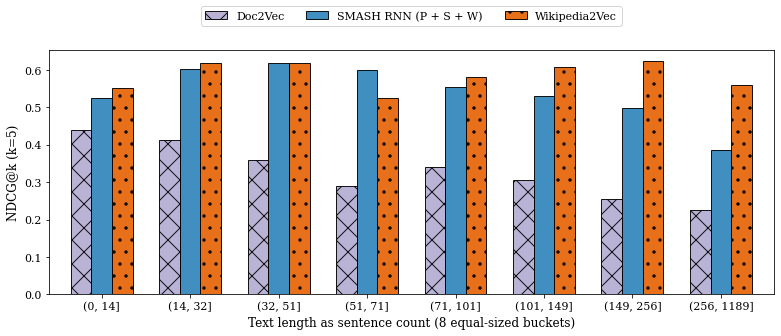

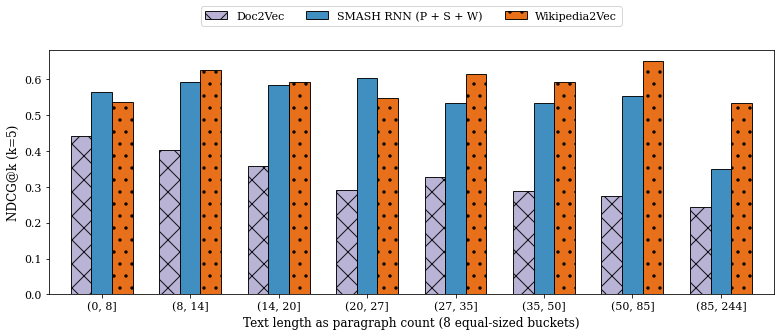

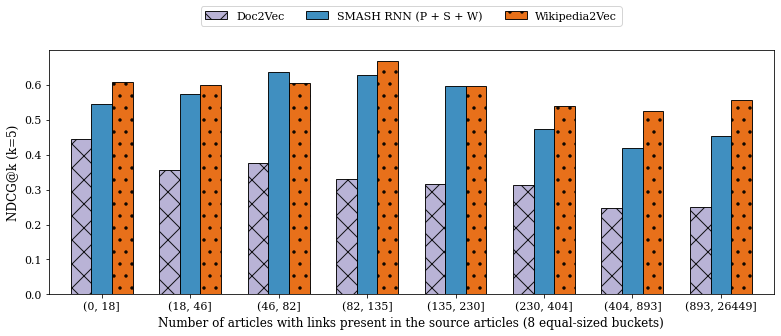

In [37]:
selected_models = BEST_MODELS
n_buckets = 8

get_performance_figure(_results, BEST_MODELS, WORD_COUNT_COLUMN, "Number of links present in the source articles (%s equal-sized buckets)", buckets_count=n_buckets, save_file_name="best_models_word_count")
get_performance_figure(_results, BEST_MODELS, SENTENCE_COUNT_COLUMN, "Text length as sentence count (%s equal-sized buckets)", buckets_count=n_buckets, save_file_name="best_models_sentence_count")
get_performance_figure(_results, BEST_MODELS, PARAGRAPH_COUNT_COLUMN, "Text length as paragraph count (%s equal-sized buckets)", buckets_count=n_buckets, save_file_name="best_models_paragraph_count")
get_performance_figure(_results, 
                       BEST_MODELS, 
                       IN_LINKS_COLUMN, 
                       "Number of articles with links present in the source articles (%s equal-sized buckets)",
                       buckets_count=n_buckets, 
                       save_file_name="best_models_in_links")


# results

In [ ]:
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return list(zip_longest(*args))


In [ ]:
def get_performance_figure_multiple_rows(
    results,
    models,
    feature_column,
    x_label,
    y_label=None,
    figsize=(15, 13),
    legend_columns_count=3,
    buckets_count=9,
    charts_per_row=3,
    save_file_name=None,
):
    bin_column = f"{feature_column}_bin"
    bins = pd.qcut(results[feature_column], q=buckets_count)

#     bins = pd.cut(results[feature_column], bins=[0, 0.05, 0.1, 0.25, 1])

    results[bin_column] = bins
    result_by_model = results.groupby([bin_column]).mean()[models]

    fig = plt.figure(figsize=figsize)
    
    groups = grouper(range(buckets_count), charts_per_row)
    
    results_by_group = []
    n_rows = len(groups)
    for index, group in enumerate(groups):
        fig.add_subplot(n_rows, 1, index + 1)
        ax = result_by_model.take(group).plot(kind="bar", ax=fig.gca(), rot=0, width=0.7, alpha=0.9, edgecolor=["black"], xlabel="")
        ax.get_legend().remove()
        
        # Formats the x label as "(lower, upper]"
        if feature_column == MISSING_WORDS_COLUMN:
            ax.set_xticklabels([f"({i.left:0.0%}, {i.right:0.0%}]" for i in bins.cat.categories[group[0]:(group[-1] + 1)]])
        else:
            ax.set_xticklabels([f"({int(i.left)}, {int(i.right)}]" for i in bins.cat.categories[group[0]:(group[-1] + 1)]])
        
        y_label = "NDCG@k (k=5)"
        ax.set_ylabel(y_label)

        # Formats the bars
        for container in ax.containers:
            container_system = container.get_label()

            style = system_styles[container_system]
            for patch in container.patches:
                if 'color' in style:
                    patch.set_color(style['color'])
                if 'hatch' in style:
                    patch.set_hatch(style['hatch'])
                if 'linewidth' in style:
                    patch.set_linewidth(style['linewidth'])
                if 'edgecolor' in style:
                    patch.set_edgecolor(style['edgecolor'])
                else:
                    patch.set_edgecolor('black')
                   
    ax.set_xlabel(x_label % len(result_by_model))
    
    top_limits = [axis.get_ylim()[1] for axis in fig.get_axes()]
    max_top_limit = max(top_limits)
    for axis in fig.get_axes():
        axis.set_ylim(top=max_top_limit)

    
    model_names = [CLEAN_MODEL_NAMES[model] for model in models]

    fig.legend(
        model_names,
        ncol=legend_columns_count,
        loc="upper center",
        fancybox=True,
        shadow=False,
        bbox_to_anchor=(0.5, 0.93),
    )
    
    if save_file_name:
        save_file_path = f"./results/figures/{save_file_name}.png"
        pdf_dpi = 300

#         logger.info(f"Saved to {save_file_path}")
        plt.savefig(save_file_path, bbox_inches="tight", dpi=pdf_dpi)

    plt.show()

In [ ]:

get_performance_figure_multiple_rows(_results, 
                                     COMPLETE_MODELS, 
                                     IN_LINKS_COLUMN, 
                                     "Number of articles with links present in the source articles (%s equal-sized buckets)",
                                     buckets_count=20, 
                                     charts_per_row=4,
                                     save_file_name="in_links_count")

In [47]:
df = pd.DataFrame([[1, 2], [4, 5], [7, 8], [30, 50]],
     index=['cobra', 'cobra', 'viper', 'sidewinder'],
     columns=['max_speed', 'shield'])
df.reset_index(inplace=True)

df.loc[df["index"] == "cobra"]

,index,max_speed,shield
0,cobra,1,2
1,cobra,4,5


In [ ]:
_results.describe()

In [ ]:
_results[_results["missing_words_percentage"].isin(_results["missing_words_percentage"].nlargest(5))][["source_article", WIKIPEDIA2VEC_SIAMESE,
         DOC2VEC_SIAMESE,
        SMASH_WORD_LEVEL, 
        SMASH_SENTENCE_LEVEL,
        SMASH_PARAGRAPH_LEVEL,]]

In [ ]:
def get_correlation():
    m = [WIKIPEDIA2VEC_SIAMESE,
         DOC2VEC_SIAMESE,
        SMASH_WORD_LEVEL, 
        SMASH_SENTENCE_LEVEL,
        SMASH_PARAGRAPH_LEVEL,]
    
    filtered_results = _results
    
    for model in m:
        correlation = round(np.corrcoef(filtered_results["missing_words_percentage"], filtered_results[model])[0, 1],4)
        
        print(f"Correlation {CLEAN_MODEL_NAMES[model]}: {correlation}")
        
get_correlation()